In [1]:
import os
import sys
sys.path.append('../')
sys.path.append('../selections')
sys.path.append('../utils')
from os.path import join
import yaml
import uproot
import numpy as np
from matplotlib import pyplot as plt
from coffea import processor, util, hist
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema
from processors.analysis_processor import AnalysisProcessor
from utils.sample_utils import  *
from pileup.pileup_utils import *

    
source = 'signal_UL'
year = '2018'
is_UL = 'UL' in source
is_data = 'data' in source
sys.path.append("../")
indir = "../sample_lists/sample_yamls"
fileset = get_fileset(join(indir, f'{source}_{year}.yaml'))
fileset = {key: val[:1] for key, val in fileset.items()
           if (('M700' not in key)
               and ('M2000' not in key) 
               and ('M225' not in key)
               and ('BBA' not in key))}
infile = f"../sample_lists/{source}_{year}.csv"
sample_info = load_sample_info(infile)
#pileup_tables, bins = get_pileup_tables(fileset.keys(), 2018, 
#                                        UL=('UL' in source),
#                                        pileup_dir='../pileup')
#a = pileup_tables[list(fileset.keys())[0]]
pileup_tables = None

In [2]:
processor_instance=AnalysisProcessor(sample_info=sample_info,
                                     pileup_tables=pileup_tables)

out = processor.run_uproot_job(
        fileset,
        treename="Events",
        processor_instance=processor_instance,
        executor=processor.futures_executor,
        executor_args={"schema": NanoAODSchema, 'workers': 20},
)

Preprocessing:   0%|          | 0/18 [00:00<?, ?file/s]

Processing:   0%|          | 0/18 [00:00<?, ?chunk/s]

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference in

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for

...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


 GluGluToAToZhToLLTauTauM1000_2018

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(


...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(


...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(


...processing GluGluToAToZhToLLTauTauM325_2018

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(


GluGluToAToZhToLLTauTauM1800_2018

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index

...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference inde

GluGluToAToZhToLLTauTauM900_2018

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau

 GluGluToAToZhToLLTauTauM600_2018


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missin

...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(


...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(


GluGluToAToZhToLLTauTauM1400_2018


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index 

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(


GluGluToAToZhToLLTauTauM1600_2018

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference in

...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(


...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index fo

...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(


 ...processing 

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(


...processingGluGluToAToZhToLLTauTauM800_2018

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(


...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(


GluGluToAToZhToLLTauTauM450_2018

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(


GluGluToAToZhToLLTauTauM375_2018...processingGluGluToAToZhToLLTauTauM1200_2018GluGluToAToZhToLLTauTauM400_2018...processingGluGluToAToZhToLLTauTauM750_2018




/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(



 ...processing

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(


 GluGluToAToZhToLLTauTauM350_2018GluGluToAToZhToLLTauTauM300_2018 

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(


...processing


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(



GluGluToAToZhToLLTauTauM500_2018 

/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_genPartIdx => GenPart
  warnings.warn(


GluGluToAToZhToLLTauTauM275_2018


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(



...processing GluGluToAToZhToLLTauTauM250_2018


mtt
['mass_type', 'mass']


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value

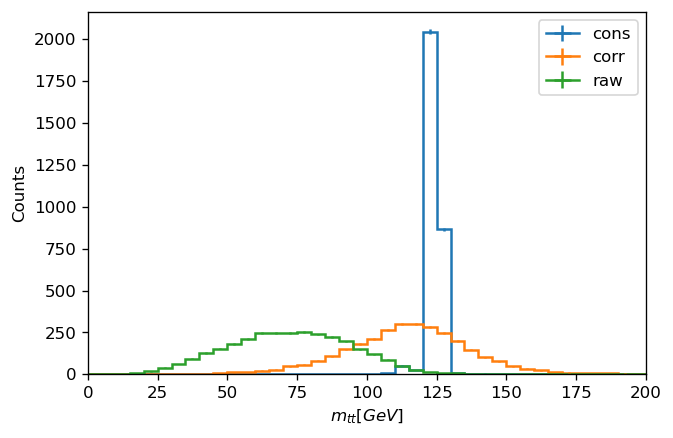

m4l
['mass_type', 'mass']


/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/uscms_data/d3/jdezoort/miniconda3/envs/AZh/lib/python3.8/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value

<Figure size 432x288 with 0 Axes>

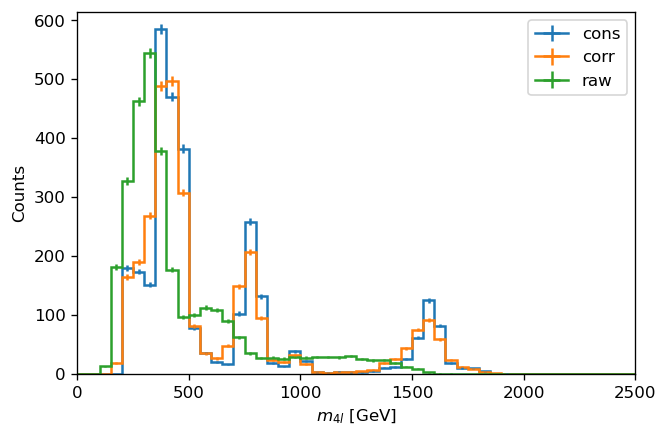

<Figure size 432x288 with 0 Axes>

In [5]:
for m in ['mtt', 'm4l']:
    print(m)
    mass = out[m]
    mass = mass.sum('dataset', overflow='none')
    mass = mass.sum('category', overflow='none')
    mass = mass.sum('group', overflow='none')
    mass = mass.sum('tight', overflow='none')
    mass = mass[:,'0 b-jets',:]
    mass = mass.sum('bjets', overflow='none')
    print(mass.fields)

    fig, ax = plt.subplots(dpi=120)
    hist.plot1d(mass, ax=ax, overlay='mass_type')
    plt.show()
    plt.clf()

#axs[0].set_title('Denominator')
#hist.plot1d(numerator, ax=axs[1], overlay='fake')
#axs[1].set_title('Numerator')
#plt.suptitle(f"{pt_range}, {eta_range}", y=1.02)
#plt.show()

In [ ]:
# ls /eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/GluGluToAToZhToLLTauTauM1400
base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/GluGluToAToZhToLLTauTauM1400'
file = join(base, 'all_GluGluToAToZhToLLTauTauM1400_file001_part_1of3_Electrons.root')
events = NanoEventsFactory.from_root(file, schemaclass=NanoAODSchema).events()

In [ ]:
base = '/eos/uscms/store/group/lpcsusyhiggs/ntuples/AZh/nAODv9/2018/GluGluToAToZhToLLTauTauM1000'
file1 = join(base, 'all_GluGluToAToZhToLLTauTauM1000_file001_part_1of3_Electrons.root')
file2 = join(base, 'all_GluGluToAToZhToLLTauTauM1000_file001_part_1of3_Muons.root')
events = NanoEventsFactory.from_root(file2, schemaclass=NanoAODSchema).events()

In [ ]:
from cutflow import Cutflow
from coffea import analysis_tools
from preselections import *

cutflow = Cutflow()
global_selections = analysis_tools.PackedSelection()
filter_MET(events, global_selections, cutflow, year,
           UL=is_UL, data=is_data)
filter_PV(events, global_selections, cutflow)
global_mask = global_selections.all(*global_selections.names)
events = events[global_mask]

weights = analysis_tools.Weights(len(events))
ones = np.ones(len(events))
weights.add('sample_weight', ones*1)

# grab baselinely defined leptons
baseline_e = get_baseline_electrons(events.Electron, cutflow)
baseline_m = get_baseline_muons(events.Muon, cutflow)
baseline_t = get_baseline_taus(events.Tau, cutflow, is_UL=is_UL)
baseline_j = get_baseline_jets(events.Jet, cutflow)
baseline_b = get_baseline_bjets(baseline_j, cutflow)

# count the number of leptons per event
e_counts = ak.num(baseline_e)
m_counts = ak.num(baseline_m)
b_counts = ak.num(baseline_b)

In [ ]:
categories = {1: 'eeet', 2: 'eemt', 3: 'eett', 4: 'eeem',
              5: 'mmet', 6: 'mmmt', 7: 'mmtt', 8: 'mmem'}

for num, cat in categories.items():
    print(cat)

    # event-level masks
    mask = check_trigger_path(events.HLT, year, cat, cutflow)
    mask = mask & lepton_count_veto(e_counts, m_counts,
                                    cat, cutflow)
    #mask = mask & bjet_veto(baseline_b, self.cutflow)

    # build Zll candidate, check trigger filter
    if (cat[:2]=='ee'):
        ll = ak.combinations(baseline_e, 2, axis=1,
                             fields=['l1', 'l2'])
    elif (cat[:2]=='mm'):
        ll = ak.combinations(baseline_m, 2, axis=1,
                             fields=['l1', 'l2'])
    ll = dR_ll(ll, cutflow)
    ll = build_Z_cand(ll, cutflow)
    mask = mask & trigger_filter(ll, events.TrigObj,
                                 cat, cutflow)
    
    # build di-tau candidate
    if cat[2:]=='mt':
        tt = ak.cartesian({'t1': baseline_m, 't2': baseline_t}, axis=1)
    elif cat[2:]=='et':
        tt = ak.cartesian({'t1': baseline_e, 't2': baseline_t}, axis=1)
    elif cat[2:]=='em':
        tt = ak.cartesian({'t1': baseline_e, 't2': baseline_m}, axis=1)
    elif cat[2:]=='tt':
        tt = ak.combinations(baseline_t, 2, axis=1, fields=['t1', 't2'])

    # build 4l final state
    lltt = ak.cartesian({'ll': ll, 'tt': tt}, axis=1)
    lltt = dR_lltt(lltt, cat, cutflow)
    lltt = build_ditau_cand(lltt, cat, cutflow)
    mask = mask & (ak.num(lltt, axis=1) > 0)
    lltt = lltt[mask]
    met = events.MET[mask]
    w = weights.weight()[mask]
    print(weights.weight()[mask])
    
    # tighter selections
    mask = higgsLT(lltt, cat, cutflow)
    mask = mask & iso_ID(lltt, cat, cutflow)
    lltt = lltt[mask]
    print(ak.sum(ak.num(lltt, axis=1)))